In [1]:
import time
import os
import gc

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
np.set_printoptions(precision=6, suppress=True)

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
tf.__version__

'2.3.0'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Hyperparameters

In [5]:
PRE_TRAINED = './models/pg_convnet.h5'
BEST_PATH = './models/pg_convnet_tf.h5'
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.005
EPSILON = 1e-08
BATCH_SIZE = 32

# Data preparation

In [6]:
l = np.load('./results/pg_dataset.npz', allow_pickle=True)
data_indices_2020S = l['data_indices_2020S']
output_label_2020S = l['output_label_2020S']
data_indices_2020W = l['data_indices_2020W']
output_label_2020W = l['output_label_2020W']
OUTPUT_MAXS = l['OUTPUT_MAXS']
OUTPUT_MINS = l['OUTPUT_MINS']

In [7]:
COLUMNS = ['node_len', 'node_dia', 'plant_h', 'leaf_area']

In [8]:
output_2020S_df = pd.DataFrame(output_label_2020S, index=data_indices_2020S, columns=COLUMNS)
output_2020W_df = pd.DataFrame(output_label_2020W, index=data_indices_2020W, columns=COLUMNS)

In [9]:
DIRECTORY = './images/2020_W/'
dir_list = os.listdir(DIRECTORY)
dataset_list = [direc for direc in dir_list if direc.startswith('LAI_OVER') or direc.startswith('LAI2_OVER')]
dataset_list.sort()

In [10]:
data_indices = []
input_images = []
output_labels = []
for DATE in output_2020W_df.index:
    for DIRECTORY in dataset_list:
        if DATE in DIRECTORY:
            file_list = os.listdir(f'./images/2020_W/{DIRECTORY}')
            file_list = [file for file in file_list if file.endswith('.jpg')]
            for FILE in file_list:
                TIME = pd.Timedelta(FILE.split()[-1].split('.')[0])
                if TIME >= pd.Timedelta('08:00:00') and TIME <= pd.Timedelta('16:00:00'):
                    image = Image.open(f'./images/2020_W/{DIRECTORY}/{FILE}')
                    data_indices.append(pd.Timestamp(DATE))
                    input_images.append(img_to_array(image))
                    output_labels.append(output_2020W_df.loc[DATE].values)

In [11]:
input_images = np.stack(input_images, axis=0)
output_labels = np.stack(output_labels, axis=0)
data_indices = np.array(data_indices)

In [12]:
print(len(data_indices))
print(input_images.shape)
print(output_labels.shape)

6234
(6234, 256, 256, 3)
(6234, 4)


In [13]:
data_indices, input_images, output_labels = resample(data_indices, input_images, output_labels, n_samples=4000, replace=False, random_state=4574)

In [14]:
print(len(data_indices))
print(input_images.shape)
print(output_labels.shape)

4000
(4000, 256, 256, 3)
(4000, 4)


In [15]:
gc.collect()

15

In [16]:
N_TRAIN = int(output_labels.shape[0]*.3)
train_input = input_images[:N_TRAIN, ...]
train_label = output_labels[:N_TRAIN, ...]
train_index = data_indices[:N_TRAIN]
test_input = input_images[N_TRAIN:, ...]
test_label = output_labels[N_TRAIN:, ...]
test_index = data_indices[N_TRAIN:]

In [17]:
train_index, val_index, train_input, val_input, train_label, val_label = train_test_split(train_index, train_input, train_label, test_size=0.3, shuffle=True, random_state=3101)

In [18]:
datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [19]:
train_iterator = datagen.flow(train_input, train_label, batch_size=BATCH_SIZE)
val_iterator = datagen.flow(val_input, val_label, batch_size=BATCH_SIZE)
test_iterator = datagen.flow(test_input, test_label, batch_size=BATCH_SIZE)

In [20]:
print(f'number of data set: {input_images.shape[0]}')
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')
print(f'number of test set: {test_input.shape[0]}')

number of data set: 4000
number of training set: 840
number of validation set: 360
number of test set: 2800


In [21]:
gc.collect()

0

# Model construction

In [22]:
class ResidualBlock(layers.Layer):
    def __init__(self, num_filter, stride=1):
        super(ResidualBlock, self).__init__()
        self.n = num_filter
        self.s = stride
        
        self.conv1 = layers.Conv2D(filters=self.n, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.conv2 = layers.Conv2D(filters=self.n, kernel_size=3, strides=stride, kernel_initializer='glorot_normal', padding='same')
        self.norm2 = layers.BatchNormalization()
        self.act2 = layers.Activation(activations.relu)
        self.conv3 = layers.Conv2D(filters=self.n*4, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm3 = layers.BatchNormalization()
        self.act3 = layers.Activation(activations.relu)

        self.downsample = Sequential()
        self.downsample.add(layers.Conv2D(filters=self.n*4, kernel_size=1, strides=stride, kernel_initializer='glorot_normal'))
        self.downsample.add(layers.BatchNormalization())

    def call(self, inp, training=None, **kwargs):
        shortcut = self.downsample(inp)

        inp = self.act1(self.norm1(self.conv1(inp), training=training))
        inp = self.act2(self.norm2(self.conv2(inp), training=training))
        inp = self.norm3(self.conv3(inp), training=training)

        oup = self.act3(layers.add([shortcut, inp]))

        return oup

In [23]:
def block_maker(num_filter, num_blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(ResidualBlock(num_filter, stride=stride))

    for _ in range(1, num_blocks):
        res_block.add(ResidualBlock(num_filter, stride=1))

    return res_block

In [24]:
class ResNet2D(Model):
    def __init__(self, layer_params):
        super(ResNet2D, self).__init__()
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer='glorot_normal', padding="same")
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.pool1 = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.layer1 = block_maker(num_filter=64, num_blocks=layer_params[0])
        self.layer2 = block_maker(num_filter=128, num_blocks=layer_params[1], stride=2)
        self.layer3 = block_maker(num_filter=256, num_blocks=layer_params[2], stride=2)
        self.layer4 = block_maker(num_filter=512, num_blocks=layer_params[3], stride=2)

#         self.flat = layers.Flatten()
        self.avgpool = layers.GlobalAveragePooling2D()
        self.out_norm1 = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.2)
        self.dense1 = layers.Dense(512)
        self.out_norm2 = layers.BatchNormalization()
        self.dense2 = layers.Dense(128)
        self.out_norm3 = layers.BatchNormalization()
        self.fc = layers.Dense(4)


    def call(self, inp, training=None, mask=None):
        inp = self.conv1(inp)
        inp = self.norm1(inp, training=training)
        inp = self.act1(inp)
        inp = self.pool1(inp)
        inp = self.layer1(inp, training=training)
        inp = self.layer2(inp, training=training)
        inp = self.layer3(inp, training=training)
        inp = self.layer4(inp, training=training)
        
#         inp = self.dense1(self.flat(inp))
        inp = self.avgpool(inp)
        inp = self.out_norm1(inp)
        inp = self.dropout(inp)
        inp = self.dense1(inp)
        inp = self.out_norm2(inp)
        inp = self.dense2(inp)
        inp = self.out_norm3(inp)
        output = self.fc(inp)

        return output

In [25]:
model = ResNet2D(layer_params=[2, 3, 2, 1])

In [26]:
opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
model.compile(optimizer=opt, loss='mae')
model.predict(val_input[:5, ...]/255)
model.load_weights(PRE_TRAINED)
model.save_weights(BEST_PATH) # For deep copy
model.load_weights(BEST_PATH)

In [28]:
# prediction_layer1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer='glorot_normal', padding="same")
base_model = Sequential(model.layers[:-1])
prediction_layer2 = layers.Dense(512)
prediction_layer3 = layers.Dense(128)
prediction_layer4 = layers.Dense(4)

In [29]:
base_model.trainable = False

In [30]:
new_model = Sequential([
#     prediction_layer1,
    base_model,
    prediction_layer2,
    prediction_layer3,
    prediction_layer4
])

In [31]:
gc.collect()

744

In [32]:
cbs = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=.5, patience=5, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0)

sv = callbacks.ModelCheckpoint(
    BEST_PATH, monitor='val_loss', verbose=0,
    save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)

In [33]:
opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
new_model.compile(optimizer=opt, loss='mae')
new_model.fit(train_iterator, epochs=TRAINING_EPOCHS, validation_data=val_iterator,
              verbose=1, callbacks=[cbs, sv, es]) 

Epoch 1/200
27/27 [==============================] - 16s 602ms/step - loss: 1.3547 - val_loss: 0.3129
Epoch 2/200
27/27 [==============================] - 15s 573ms/step - loss: 0.2078 - val_loss: 0.2013
Epoch 3/200
27/27 [==============================] - 15s 559ms/step - loss: 0.1383 - val_loss: 0.0974
Epoch 4/200
27/27 [==============================] - 15s 570ms/step - loss: 0.0935 - val_loss: 0.0932
Epoch 5/200
27/27 [==============================] - 15s 558ms/step - loss: 0.0914 - val_loss: 0.0727
Epoch 6/200
27/27 [==============================] - 15s 551ms/step - loss: 0.0918 - val_loss: 0.0856
Epoch 7/200
27/27 [==============================] - 15s 556ms/step - loss: 0.0834 - val_loss: 0.0783
Epoch 8/200
27/27 [==============================] - 15s 565ms/step - loss: 0.0884 - val_loss: 0.0723
Epoch 9/200
27/27 [==============================] - 15s 552ms/step - loss: 0.0955 - val_loss: 0.0992
Epoch 10/200
27/27 [==============================] - 15s 552ms/step - loss: 0.086

In [34]:
pred_result_prev = new_model.predict(test_input/255)

In [35]:
new_model.load_weights(BEST_PATH)

In [36]:
new_model.evaluate(val_iterator)

12/12 [==============================] - 4s 343ms/step - loss: 0.0600


0.05999937653541565

In [37]:
del(train_index)
del(train_input)
del(train_iterator)
del(train_label)
del(val_index)
del(val_input)
del(val_iterator)
del(val_label)

In [38]:
gc.collect()

731

In [39]:
pred_result = new_model.predict(test_input/255)

In [40]:
abs(pred_result - pred_result_prev).max()

0.046640888

In [41]:
print(pred_result.shape)
print(test_label.shape)

(2800, 4)
(2800, 4)


In [42]:
test_label = (OUTPUT_MAXS - OUTPUT_MINS)*test_label + OUTPUT_MINS
pred_result = (OUTPUT_MAXS - OUTPUT_MINS)*pred_result + OUTPUT_MINS

In [43]:
pred_df = pd.DataFrame(np.concatenate([test_label, pred_result], axis=1), index=test_index)
pred_df.columns = ['label_node_len', 'label_node_dia', 'label_plant_h', 'label_leaf_area', 'pred_node_len', 'pred_node_dia', 'pred_plant_h', 'pred_leaf_area']

In [44]:
pred_df.to_csv('./results/model_output/pg_pred_result_tr.csv')

In [45]:
pred_df = pred_df.sort_index()

In [46]:
label_df = pred_df.loc[:, [col for col in pred_df.columns if col.startswith('label')]]
pred_df = pred_df.loc[:, [col for col in pred_df.columns if col.startswith('pred')]]

In [47]:
pred_max_df = pred_df.groupby(pred_df.index).max()
pred_min_df = pred_df.groupby(pred_df.index).min()

In [48]:
def is_outlier(s):
    lower_limit = s.mean() - s.std()
    upper_limit = s.mean() + s.std()
    return ~s.between(lower_limit, upper_limit)

In [49]:
tamp_df = []
for _ in pred_df.columns:
    tamp_s = pred_df.loc[~pred_df.groupby(pred_df.index)[_].apply(is_outlier)][_]
    tamp_s = tamp_s.groupby(tamp_s.index).mean()
    tamp_df.append(tamp_s)

In [50]:
label_df = label_df.groupby(label_df.index).mean()
pred_df = pd.concat(tamp_df,axis=1)

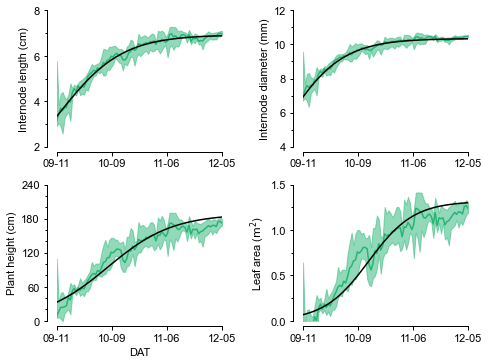

In [51]:
fig = plt.figure(figsize=((8/2.54*2.2), (6/2.54*2.2)))
grid = plt.GridSpec(2, 2)

ax0 = plt.subplot(grid[0])
ax1 = plt.subplot(grid[1])
ax2 = plt.subplot(grid[2])
ax3 = plt.subplot(grid[3])

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 10))
ax0.spines['bottom'].set_position(('outward', 5))
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_position(('outward', 10))
ax1.spines['bottom'].set_position(('outward', 5))
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 5))
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_position(('outward', 10))
ax3.spines['bottom'].set_position(('outward', 5))

ax0.plot(pred_df.index, pred_df['pred_node_len'], '-', c=cmap[3])
ax1.plot(pred_df.index, pred_df['pred_node_dia'], '-', c=cmap[3])
ax2.plot(pred_df.index, pred_df['pred_plant_h'], '-', c=cmap[3])
ax3.plot(pred_df.index, pred_df['pred_leaf_area'], '-', c=cmap[3])

ax0.fill_between(pred_df.index, pred_min_df['pred_node_len'], pred_max_df['pred_node_len'], color=cmap[3], alpha=0.5)
ax1.fill_between(pred_df.index, pred_min_df['pred_node_dia'], pred_max_df['pred_node_dia'], color=cmap[3], alpha=0.5)
ax2.fill_between(pred_df.index, pred_min_df['pred_plant_h'], pred_max_df['pred_plant_h'], color=cmap[3], alpha=0.5)
ax3.fill_between(pred_df.index, pred_min_df['pred_leaf_area'], pred_max_df['pred_leaf_area'], color=cmap[3], alpha=0.5)

ax0.plot(label_df.index, label_df['label_node_len'], '-', c='k')
ax1.plot(label_df.index, label_df['label_node_dia'], '-', c='k')
ax2.plot(label_df.index, label_df['label_plant_h'], '-', c='k')
ax3.plot(label_df.index, label_df['label_leaf_area'], '-', c='k')

ax0.set_xbound(pred_df.index[0], pred_df.index[-1])
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax0.xaxis.set_major_locator(LinearLocator(4))
ax0.yaxis.set_major_locator(LinearLocator(4))
ax0.yaxis.set_minor_locator(LinearLocator(7))
ax0.set_ybound(2, 8)
ax1.set_xbound(pred_df.index[0], pred_df.index[-1])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(LinearLocator(4))
ax1.yaxis.set_major_locator(LinearLocator(5))
ax1.yaxis.set_minor_locator(LinearLocator(9))
ax1.set_ybound(4, 12)
ax2.set_xbound(pred_df.index[0], pred_df.index[-1])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(LinearLocator(4))
ax2.yaxis.set_major_locator(LinearLocator(5))
ax2.yaxis.set_minor_locator(LinearLocator(13))
ax2.set_ybound(0, 240)
ax3.set_xbound(pred_df.index[0], pred_df.index[-1])
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.xaxis.set_major_locator(LinearLocator(4))
ax3.yaxis.set_major_locator(LinearLocator(4))
ax3.yaxis.set_minor_locator(LinearLocator(7))
ax3.set_ybound(0, 1.5)

ax0.set_ylabel('Internode length (cm)')
ax1.set_ylabel('Internode diameter (mm)')
ax2.set_xlabel('DAT')
ax2.set_ylabel('Plant height (cm)')
ax3.set_ylabel('Leaf area ($m^2$)')

fig.tight_layout()
plt.show()